## Malaria Financing and Eradication Figures and Notes

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.nonparametric.smoothers_lowess import lowess
from scipy.integrate import simps
from numpy import trapz
from functools import reduce
import re

In [2]:
# import data
cases = pd.read_csv('~/malaria_proj/data/IHME_cases.csv')
financing = pd.read_csv('~/malaria_proj/data/country_level_dataset.csv')
population = pd.read_csv('~/malaria_proj/data/population.csv')
rank = pd.read_csv('~/malaria_proj/data/Rank.csv')

In [3]:
# cleaning malaria case data
# we are only interested in the incidence measure for malaria and the country, year and value columns
cases = cases[cases['measure'] == 'Incidence'][['country', 'year', 'val']]

# we rename the val column here to incidence
cases = cases.rename(columns={'val': 'incidence'})

In [4]:
# smoothing Development Assistance for Health data by country
def smooth_data(df, country):
    """
    This function is used to perform a loess regression on a dataset (df) containing development
    assistance for health data for a particular country (country) 
    """
    df = df[df['country'] == country].reset_index(drop = True)
    smooth = lowess(df['dah'], df['year'], frac = 0.67) # this frac number was optimized through a separate analysis
    smooth = pd.DataFrame(smooth, columns=['year', 'dah_smooth'])
    smooth.year = smooth.year.astype(int)
    df = df.merge(smooth, on = 'year')
    df.dah_smooth[df.dah_smooth < 0 ] = 0
    df['the_smooth'] = df['dah_smooth'] + \
                       df['oop'] + \
                       df['ghes']+ \
                       df['ppp']
    return df

In [5]:
countries = financing.country.unique()
df_list = []
# we perform the smoothing over each country in our dataset, append the new data to a list, which we reduce later
# to form the new version of financing data to use in our analysis
for country in countries:
    df = smooth_data(financing, country)
    df_list.append(df)
financing = reduce(lambda x, y: x.append(y, ignore_index = True), df_list)
del df_list

C:\Users\marga\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


In [6]:
# combine all data for use in plots
all_data = financing.merge(population, on = ['country', 'year'], how = 'left')\
            .merge(cases, on = ['country', 'year'] )\
            .drop(['iso3', 'the', 'dah'],axis=1)

# calculate per capita expenditure
all_data['ghes_per_capita'] = all_data['ghes']/all_data['population']
all_data['the_per_capita'] = all_data['the_smooth']/all_data['population']
all_data['oop_per_capita'] = all_data['oop']/all_data['population']
all_data['dah_per_capita'] = all_data['dah_smooth']/all_data['population']

#converte USD to Billions of USD
all_data['the_bil'] = all_data['the_smooth']/(10**9)
all_data['ghes_bil'] = all_data['ghes']/(10**9)
all_data['oop_bil'] = all_data['oop']/(10**9)
all_data['dah_bil'] = all_data['dah_smooth']/(10**9)

# calculate the incidence per 1000 people
all_data['incidence_per_1000'] = all_data['incidence']/all_data['population']*1000
 
all_data.head()

,country,year,ghes,oop,ppp,dah_smooth,the_smooth,population,incidence,ghes_per_capita,the_per_capita,oop_per_capita,dah_per_capita,the_bil,ghes_bil,oop_bil,dah_bil,incidence_per_1000
0,Afghanistan,2000,170531.0994,421066.5934,489.218337,0.000000e+00,5.920869e+05,17929000,608718.5980,0.009511,0.033024,0.023485,0.000000,0.000592,0.000171,0.000421,0.000000,33.951620
1,Afghanistan,2001,197231.1266,435870.5588,402.346461,4.291817e+04,6.764222e+05,18266000,631991.0955,0.010798,0.037032,0.023862,0.002350,0.000676,0.000197,0.000436,0.000043,34.599315
2,Afghanistan,2002,251812.1920,535221.6844,1586.478345,5.679597e+05,1.356580e+06,19459000,708431.9564,0.012941,0.069715,0.027505,0.029188,0.001357,0.000252,0.000535,0.000568,36.406391
3,Afghanistan,2003,341777.9410,648580.5960,932.578699,1.151777e+06,2.143068e+06,20768000,801475.9143,0.016457,0.103191,0.031230,0.055459,0.002143,0.000342,0.000649,0.001152,38.591868
4,Afghanistan,2004,454833.1979,700649.2820,1763.716492,1.787757e+06,2.945003e+06,21430000,865452.1167,0.021224,0.137424,0.032695,0.083423,0.002945,0.000455,0.000701,0.001788,40.385073


In [7]:
# generate summary data for the year 2000
table2 = all_data[all_data['year']== 2000].drop('year', axis = 1).reset_index(drop = True)
table2.describe()

,ghes,oop,ppp,dah_smooth,the_smooth,population,incidence,ghes_per_capita,the_per_capita,oop_per_capita,dah_per_capita,the_bil,ghes_bil,oop_bil,dah_bil,incidence_per_1000
count,1.060000e+02,1.060000e+02,1.060000e+02,1.060000e+02,1.060000e+02,1.060000e+02,1.060000e+02,106.000000,106.000000,1.060000e+02,106.000000,106.000000,106.000000,1.060000e+02,1.060000e+02,106.000000
mean,6.062449e+06,2.895927e+06,3.916764e+05,3.004971e+05,9.650550e+06,4.577456e+07,2.265403e+06,0.624424,0.888233,2.168935e-01,0.016931,0.009651,0.006062,2.895927e-03,3.004971e-04,138.936063
std,1.071244e+07,8.081235e+06,1.049265e+06,2.092837e+06,1.785809e+07,1.625055e+08,5.899439e+06,1.039587,1.390975,4.251611e-01,0.109834,0.017858,0.010712,8.081235e-03,2.092837e-03,173.831596
min,6.835948e+04,7.033184e-01,9.146505e-02,0.000000e+00,6.839644e+04,1.430000e+05,0.000000e+00,0.001161,0.001468,7.748012e-08,0.000000,0.000068,0.000068,7.033184e-10,0.000000e+00,0.000000
25%,9.169051e+05,2.283558e+04,9.907321e+03,0.000000e+00,1.390346e+06,3.986250e+06,1.335289e+04,0.088189,0.109900,2.416251e-03,0.000000,0.001390,0.000917,2.283558e-05,0.000000e+00,1.534874
50%,2.257152e+06,3.988919e+05,5.569445e+04,0.000000e+00,3.199225e+06,1.098400e+07,2.335054e+05,0.332531,0.414970,3.031958e-02,0.000000,0.003199,0.002257,3.988919e-04,0.000000e+00,31.922088
75%,6.602754e+06,1.871466e+06,2.371672e+05,3.521323e+02,9.738120e+06,2.623125e+07,2.077245e+06,0.624023,1.063169,2.768837e-01,0.000080,0.009738,0.006603,1.871466e-03,3.521323e-07,306.194370
max,7.859042e+07,6.849866e+07,8.817512e+06,2.108131e+07,1.127370e+08,1.298682e+09,4.736394e+07,6.626993,9.666485,3.007324e+00,1.117471,0.112737,0.078590,6.849866e-02,2.108131e-02,579.929485


In [8]:
# generate summary data for the year 2016
table3 = all_data[all_data['year']== 2016].drop('year', axis = 1).reset_index(drop = True)
table3.describe()

,ghes,oop,ppp,dah_smooth,the_smooth,population,incidence,ghes_per_capita,the_per_capita,oop_per_capita,dah_per_capita,the_bil,ghes_bil,oop_bil,dah_bil,incidence_per_1000
count,1.060000e+02,1.060000e+02,1.060000e+02,1.060000e+02,1.060000e+02,1.060000e+02,1.060000e+02,106.000000,106.000000,1.060000e+02,106.000000,106.000000,106.000000,1.060000e+02,106.000000,106.000000
mean,1.136607e+07,5.245923e+06,9.348185e+05,1.544559e+07,3.299240e+07,5.768039e+07,2.038287e+06,0.786894,1.924162,1.961640e-01,0.892102,0.032992,0.011366,5.245923e-03,0.015446,77.348356
std,1.708727e+07,1.759310e+07,1.699966e+06,3.195172e+07,5.985080e+07,1.907673e+08,5.722545e+06,1.312907,2.800318,3.970520e-01,1.788049,0.059851,0.017087,1.759310e-02,0.031952,118.203667
min,5.886875e+04,1.860685e-01,2.219900e-01,0.000000e+00,5.887771e+04,1.970000e+05,0.000000e+00,0.009399,0.009401,1.911641e-08,0.000000,0.000059,0.000059,1.860685e-10,0.000000,0.000000
25%,1.459899e+06,3.437176e+03,3.295011e+04,3.162576e+04,2.642839e+06,4.841250e+06,4.766521e+02,0.117356,0.221701,2.856815e-04,0.002800,0.002643,0.001460,3.437176e-06,0.000032,0.063097
50%,4.390557e+06,1.623448e+05,1.407913e+05,2.218980e+06,9.389785e+06,1.639450e+07,4.868706e+04,0.362035,1.150032,1.928832e-02,0.178142,0.009390,0.004391,1.623448e-04,0.002219,10.806447
75%,1.537202e+07,3.350376e+06,9.688062e+05,1.196001e+07,3.633378e+07,3.735350e+07,1.545854e+06,0.890562,2.587703,2.200717e-01,1.334901,0.036334,0.015372,3.350376e-03,0.011960,136.100114
max,8.130897e+07,1.616358e+08,7.923234e+06,2.186460e+08,4.641724e+08,1.403797e+09,4.884040e+07,10.417815,21.832963,2.483765e+00,15.989314,0.464172,0.081309,1.616358e-01,0.218646,402.407911


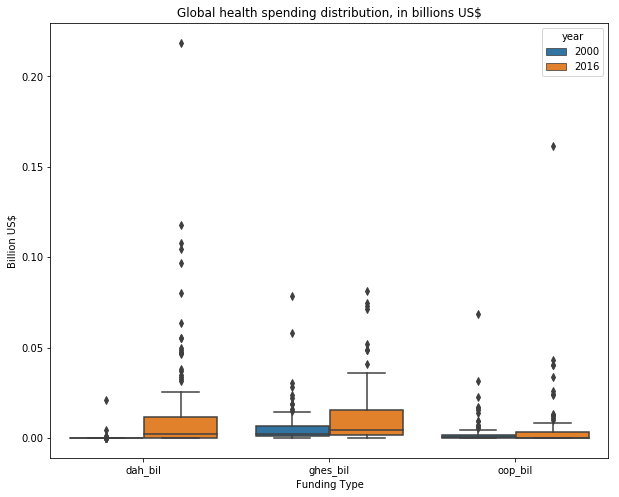

In [9]:
# take a look at financing distributions in USD Billions
df = all_data[all_data['year'].isin([2000,2016])]
df = pd.melt(df, id_vars=['year', 'country'], value_vars=['dah_bil', 'ghes_bil', 'oop_bil'], var_name='funding_type')

fig, ax = plt.subplots(figsize = (10,8))
sns.boxplot(data = df, x = 'funding_type', y = 'value', hue = 'year')
ax.set_title("Global health spending distribution, in billions US$")
ax.set_xlabel("Funding Type")
ax.set_ylabel("Billion US$")
plt.show()


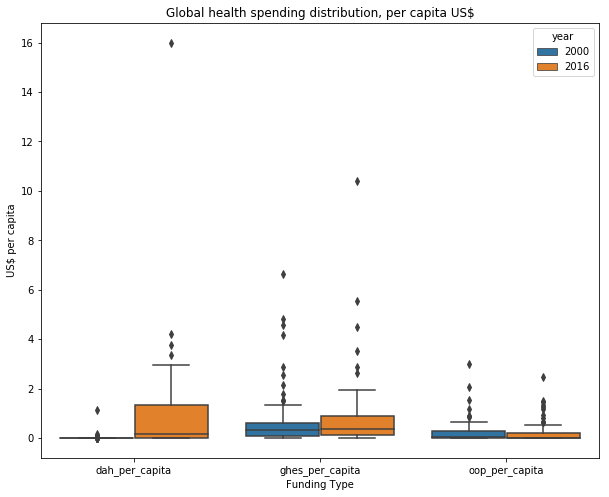

In [10]:
#financing distributions per capita
df = all_data[all_data['year'].isin([2000,2016])]
df = pd.melt(df, id_vars=['year', 'country'], value_vars=['dah_per_capita','ghes_per_capita', 'oop_per_capita'], var_name='funding_type')

fig, ax = plt.subplots(figsize = (10,8))
sns.boxplot(data = df, x = 'funding_type', y = 'value', hue = 'year')
ax.set_title("Global health spending distribution, per capita US$")
ax.set_xlabel("Funding Type")
ax.set_ylabel("US$ per capita")
plt.show()

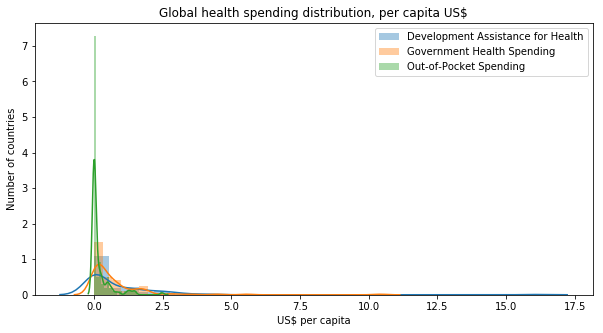

In [11]:
# take a deeper look at financing distributions per capita
yr = 2016
df = all_data[all_data['year'] == yr].reset_index()
fin_plot = df[['dah_per_capita','ghes_per_capita', 'oop_per_capita']]

fig, ax = plt.subplots(figsize = (10,5))
sns.distplot(df['dah_per_capita'], label = 'Development Assistance for Health')
sns.distplot(df['ghes_per_capita'], label = 'Government Health Spending')
sns.distplot(df['oop_per_capita'], label = 'Out-of-Pocket Spending')
ax.set_title("Global health spending distribution, per capita US$")
ax.set_xlabel("US$ per capita")
ax.set_ylabel("Number of countries")
plt.legend()
plt.show()

In [12]:
def spending_fig(data, spending_type, country_group):
    
    cols = [f'{x}_{spending_type}' for x in ['the', 'dah', 'ghes', 'oop']]
    labels = ['Total Health Spending', 'Development Assistance for Health', 'Government Health Spending','Out-of-Pocket Spending']
    estimator = np.sum if spending_type == 'bil' else np.mean
    
    fig, ax1 = plt.subplots(figsize = (15,10))

    sns.set_context("talk")
    for i in range(len(cols)):
        sns.lineplot(data['year'],data[cols[i]], ci = None, estimator = estimator, label = labels[i])
        
    ax2 = ax1.twinx()
    sns.lineplot(data['year'], data['incidence_per_1000'], ci = None, ax=ax2, color = 'black', label = 'Malaria Incidence')
    
    l = 'Billions' if spending_type == 'bil' else 'per capita'
    t = 'Total' if spending_type == 'bil' else 'Average per capita'
    
    name = re.sub(r' ', '_', country_group).lower()

    ax2.set_title(f"{t} Malaria Spending, {country_group}")
    ax1.set_xlabel('Year')
    ax2.set_ylabel('Malaria Incidence per 1,000')
    ax1.set_ylabel(f'US$ {l}')
    ax1.legend(loc = 'lower center', bbox_to_anchor=(.5, .8))
    ax2.legend(loc = 'upper center', bbox_to_anchor=(.5, .83))
    
    fig.savefig(f'{name}_spending_{spending_type}.png')
    return fig

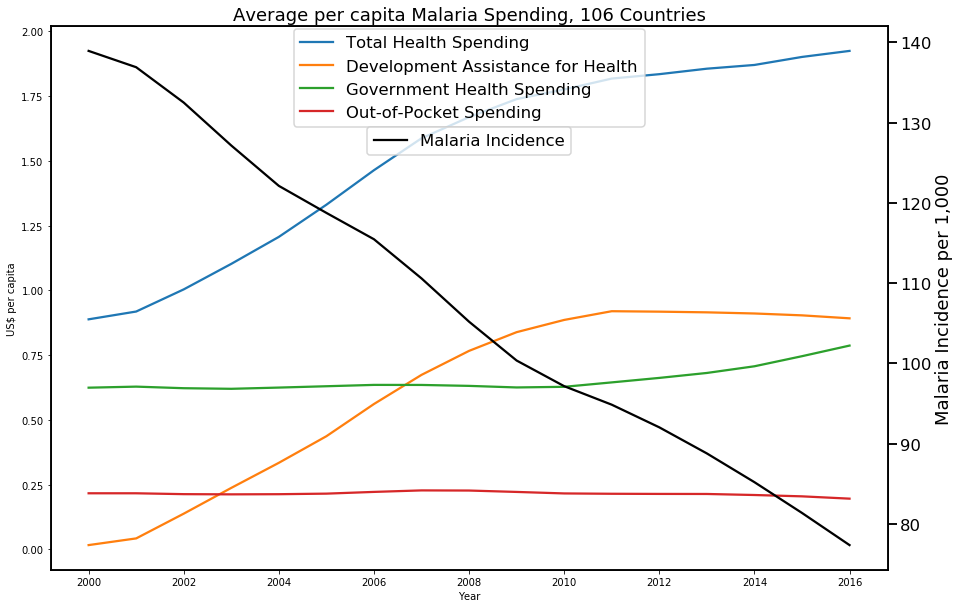

In [13]:
fig = spending_fig(all_data, 'per_capita','106 Countries')
plt.show()

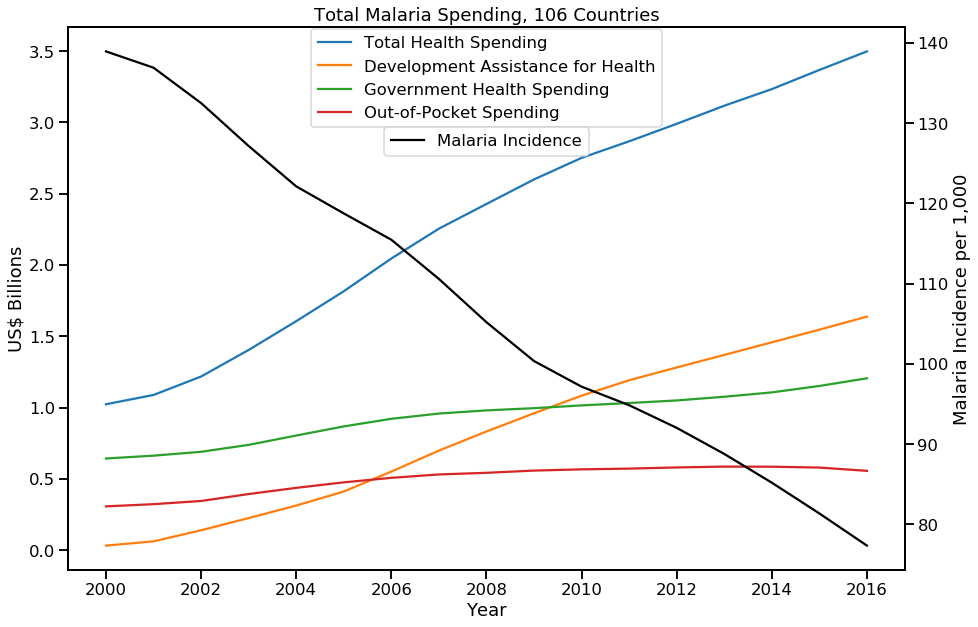

In [14]:
fig = spending_fig(all_data, 'bil','106 Countries')
plt.show()

In [15]:
# we also want to look at the top 30 and bottom 30 malarious countries and 
# see how their spending is different from the 106 countries as a whole
all_data = all_data.merge(rank, how = 'left', on = 'country')

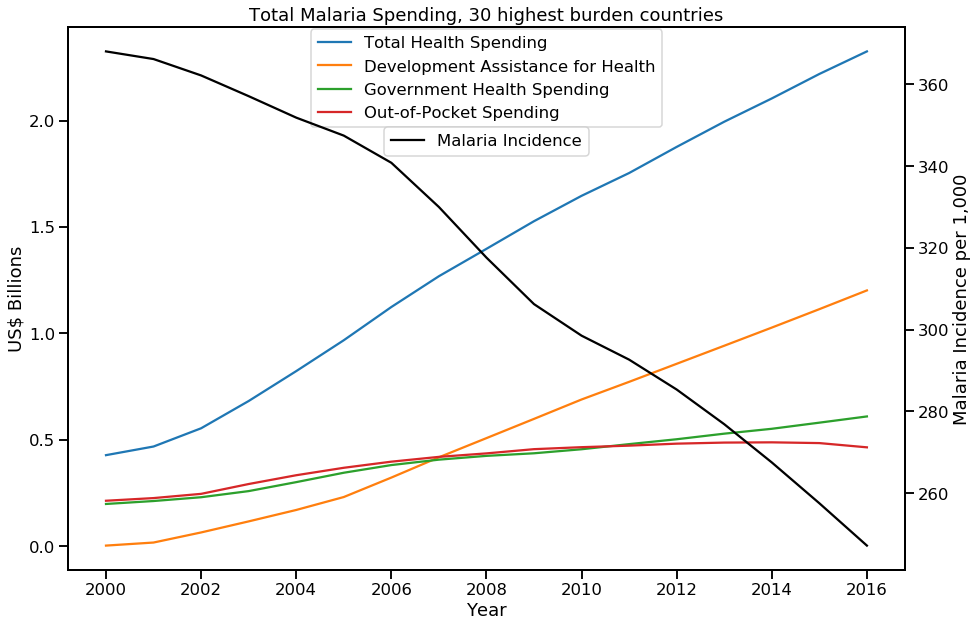

In [16]:
fig = spending_fig(all_data[(all_data['rank'] <= 30) & \
                            (all_data['rank'] > 0)].reset_index(), 
                   'bil','30 highest burden countries')
plt.show()

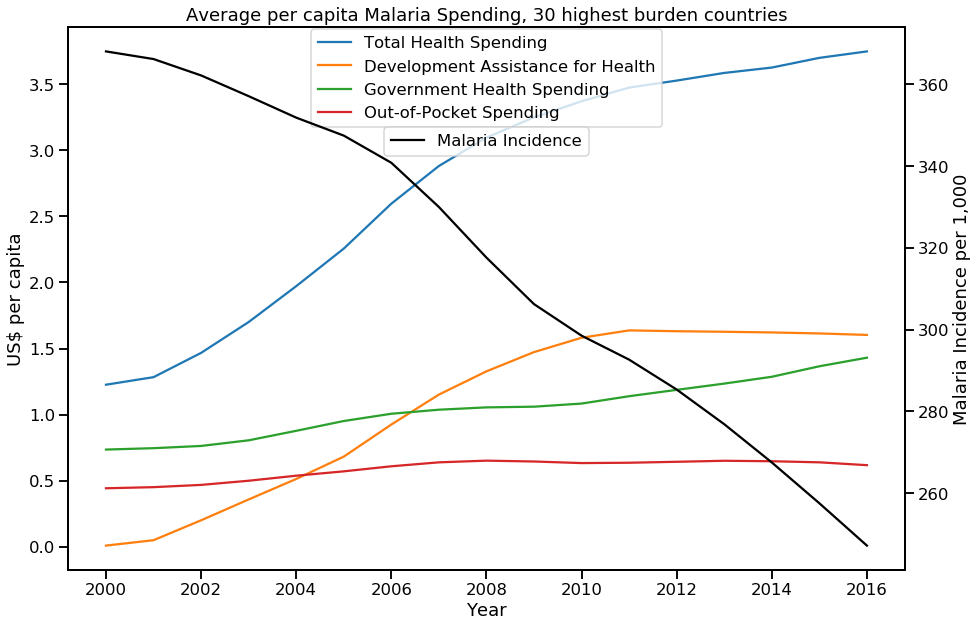

In [17]:
fig = spending_fig(all_data[(all_data['rank'] <= 30) & \
                            (all_data['rank'] > 0)].reset_index(), 
                   'per_capita','30 highest burden countries')
plt.show()

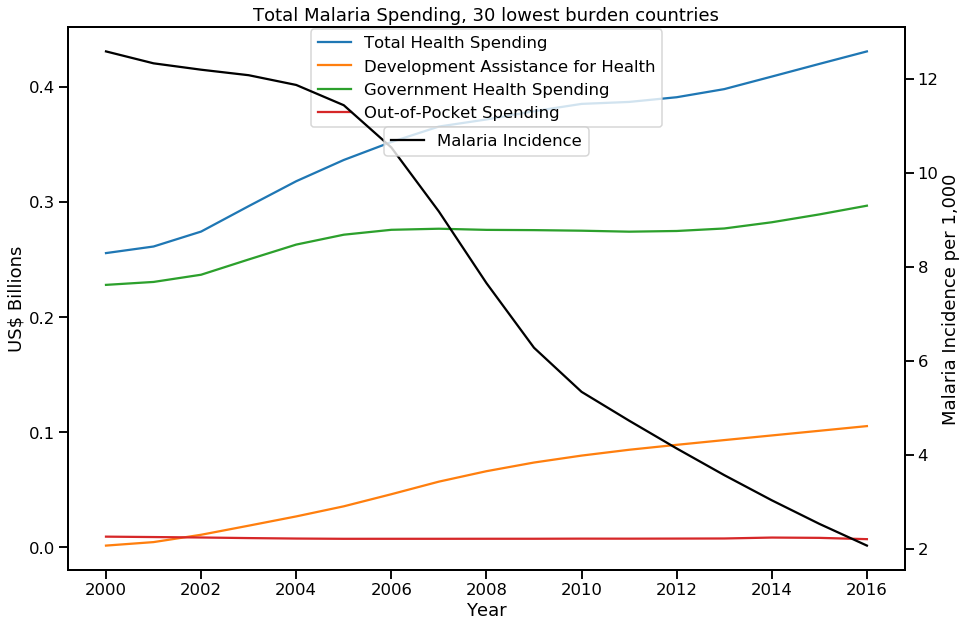

In [18]:
fig = spending_fig(all_data[all_data['rank'] >= 56].reset_index(), 
                   'bil','30 lowest burden countries')
plt.show()

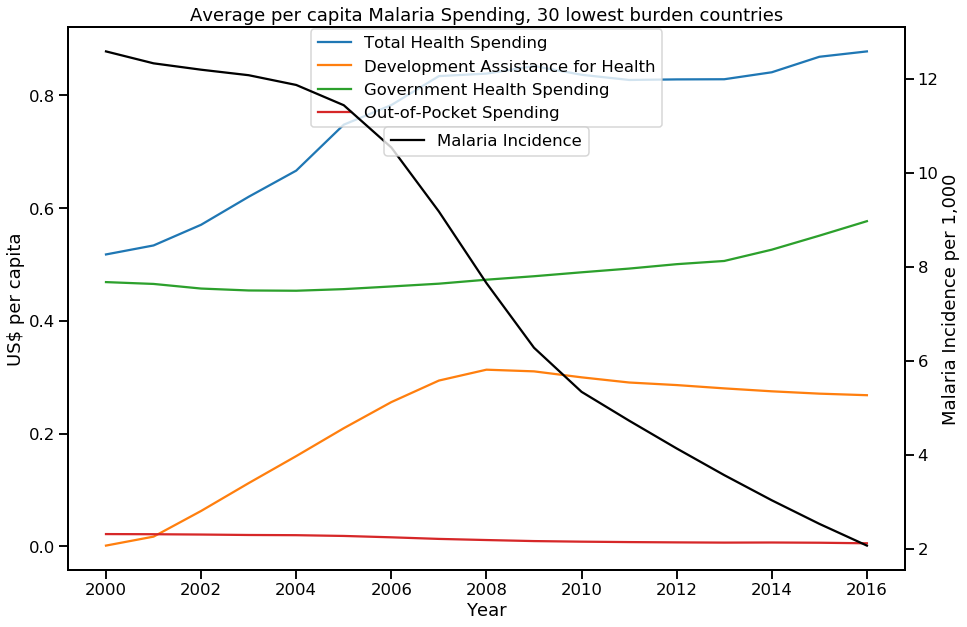

In [19]:
fig = spending_fig(all_data[all_data['rank'] >= 56].reset_index(), 
                   'per_capita','30 lowest burden countries')
plt.show()